# MLPRegressor on 5JUN2023 data

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

sklearn.exceptions.ConvergenceWarning('ignore')

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve, mean_absolute_error
from IPython.display import display
import shap
shap.initjs() # needed for shap force plots

## load data

In [31]:
df = pd.read_csv("../data/5JUN2023_Provisional_endo_study_data_to_test_AI.csv").fillna(0)
df.Sex = np.where(df.Sex == "male", 0, 1)
# df.Sex = df.Sex.astype('category')
df.head()

,Sex,A_EPM_distance,A_EPM_pct_open_arms,A_Open_field_distance,A_LOF_pct_center,RP_Withdrawal_latency,OR_lick_time,OR_num_lick_bursts,OR__Lick_burst_length,FSA_Consumption_time,DSA_1st_week_infusions,OPAD_37oC__lick_face,OPAD_46_5oC_lick_face,RP_Delta_hargreaves
0,0,1272.67,31.58,5128.37,12.46,14.48,97.350,69.25,1.372342,66.45,86.0,10.25,1.50,0.06
1,0,1272.52,18.75,5037.27,10.68,14.84,85.125,105.00,1.444197,75.28,87.0,24.75,5.50,0.17
2,0,1462.30,29.03,5340.03,19.06,11.68,205.375,112.75,1.459464,64.88,120.0,15.00,5.00,-1.38
3,0,1288.02,20.59,5384.21,5.36,12.69,185.550,71.75,1.312209,29.45,94.0,15.75,4.25,-0.41
4,0,880.52,4.35,3919.19,1.65,17.56,239.200,136.75,1.912567,61.02,108.0,18.75,5.00,2.49


## standardize and split into feature (`X`) and target (`y`) datasets

In [32]:
# determine which cols to standardize
z_cols = [
    "A_EPM_distance", 
    "A_EPM_pct_open_arms", 
    "A_Open_field_distance", 
    "A_LOF_pct_center", 
    "RP_Withdrawal_latency", 
    "OR_lick_time", 
    "OR_num_lick_bursts", 
    "OR__Lick_burst_length", 
    "FSA_Consumption_time", 
    "DSA_1st_week_infusions", 
    "OPAD_37oC__lick_face", 
    "OPAD_46_5oC_lick_face", 
    "RP_Delta_hargreaves"
]

# standarize df values
df[z_cols] = StandardScaler().fit_transform(df[z_cols]) # scale data (z scores)
df.head()

,Sex,A_EPM_distance,A_EPM_pct_open_arms,A_Open_field_distance,A_LOF_pct_center,RP_Withdrawal_latency,OR_lick_time,OR_num_lick_bursts,OR__Lick_burst_length,FSA_Consumption_time,DSA_1st_week_infusions,OPAD_37oC__lick_face,OPAD_46_5oC_lick_face,RP_Delta_hargreaves
0,0,-0.018964,0.733076,-0.131135,1.036909,0.201703,-1.263194,-0.717777,-0.528817,0.536718,-0.034145,-0.925942,-2.686533,-0.328085
1,0,-0.019549,-0.266963,-0.236146,0.667732,0.412481,-1.548823,0.864985,-0.081422,1.027931,-0.016174,1.571948,0.561995,-0.196131
2,0,0.720971,0.534316,0.112846,2.405766,-1.437681,1.260741,1.208102,0.013638,0.449379,0.576878,-0.107668,0.155929,-2.055477
3,0,0.040932,-0.123543,0.163772,-0.435649,-0.846332,0.797542,-0.607095,-0.903226,-1.521592,0.109625,0.021534,-0.453170,-0.891886
4,0,-1.549130,-1.389376,-1.524957,-1.205112,2.005024,2.051040,2.270655,2.834815,0.234647,0.361223,0.538338,0.155929,2.586891


In [33]:
X, y = df.drop('DSA_1st_week_infusions', axis=1), df.DSA_1st_week_infusions

## run model
Note: I manually experimented with the values to find best fit. This model is overfitted.

In [99]:
params = {
 'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (11,4),
 'learning_rate': 'constant',
 'solver': 'adam',
 'random_state': 42
}
model = MLPRegressor(**params)
model.fit(X, y)
model.score(X, y) # uses r-squared score; higher is better

0.9668349526289994

## SHAP values

In [109]:
# need to change int and bool to classes int_ and bool_ to handle error 'numpy' has no attribute 'int'/'bool'/etc.
np.bool = np.bool_
np.int = np.int_
np.float = np.float_

explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X)

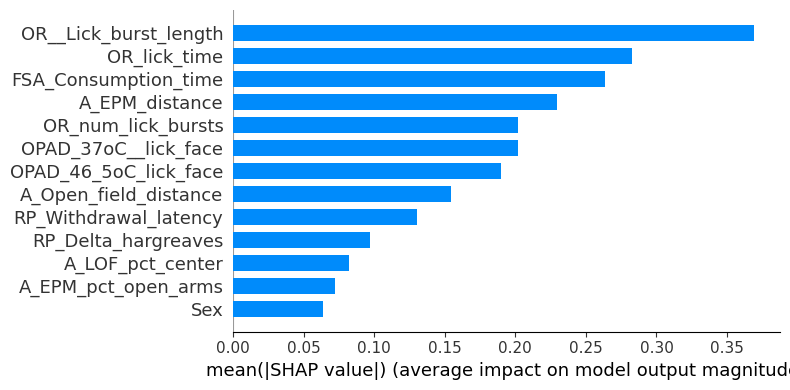

In [116]:
shap.summary_plot(shap_values, X, plot_type='bar', plot_size=(8, 4))

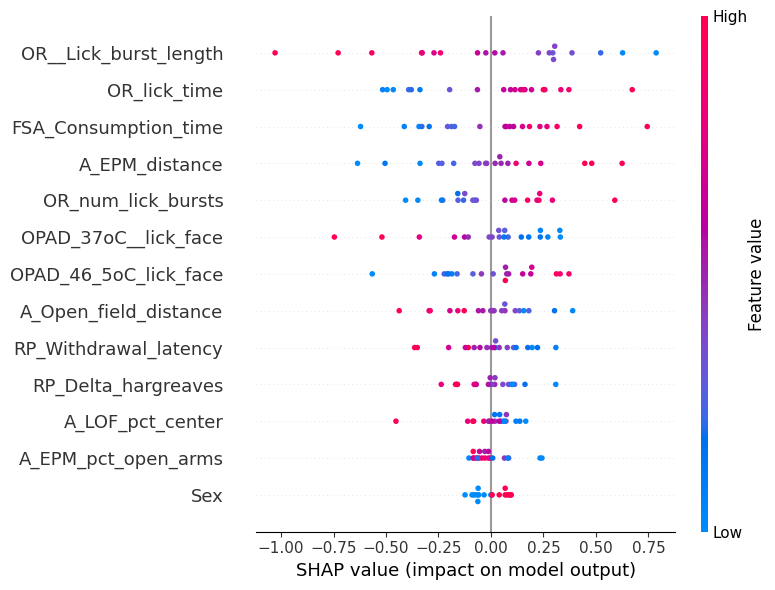

In [115]:
shap.summary_plot(shap_values, X, plot_size=(8, 6))

In [118]:
X.columns

Index(['Sex', 'A_EPM_distance', 'A_EPM_pct_open_arms', 'A_Open_field_distance',
       'A_LOF_pct_center', 'RP_Withdrawal_latency', 'OR_lick_time',
       'OR_num_lick_bursts', 'OR__Lick_burst_length', 'FSA_Consumption_time',
       'OPAD_37oC__lick_face', 'OPAD_46_5oC_lick_face', 'RP_Delta_hargreaves'],
      dtype='object')

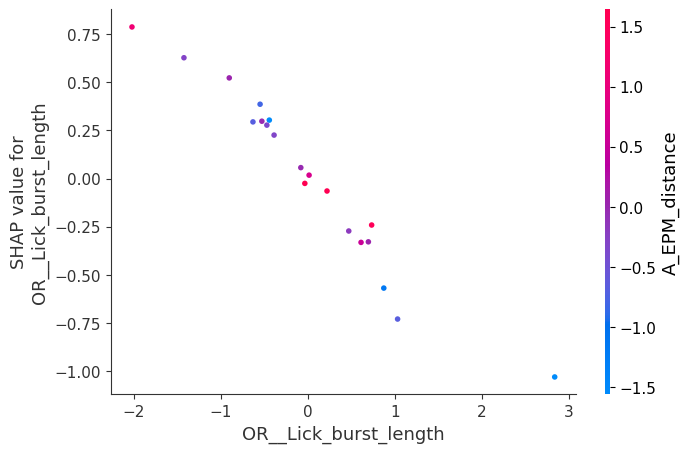

In [123]:
shap.dependence_plot("OR__Lick_burst_length", shap_values.values, X)

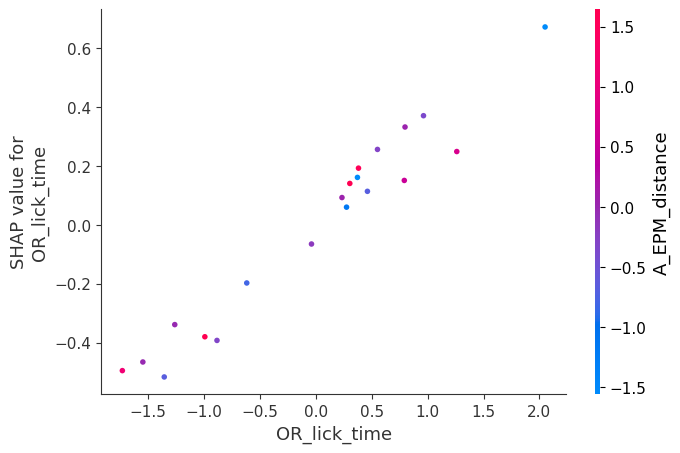

In [124]:
shap.dependence_plot("OR_lick_time", shap_values.values, X)

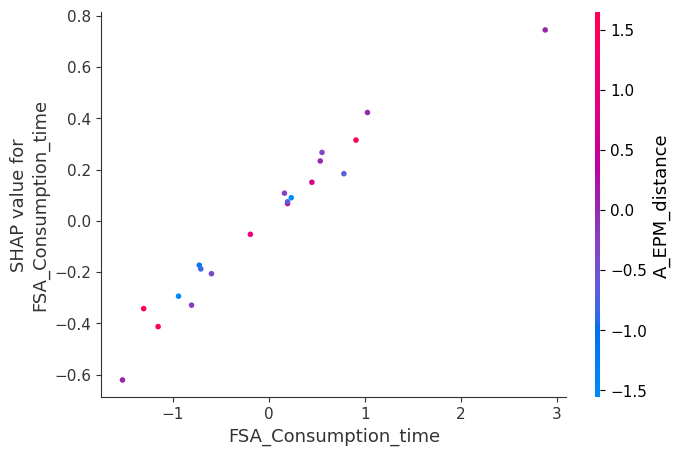

In [126]:
shap.dependence_plot("FSA_Consumption_time", shap_values.values, X)

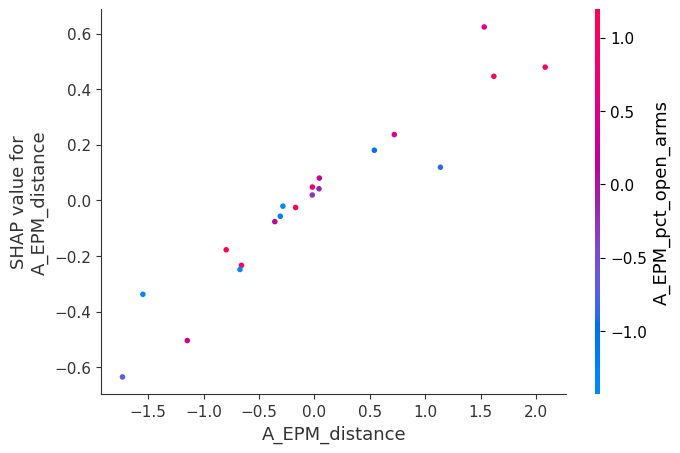

In [127]:
shap.dependence_plot("A_EPM_distance", shap_values.values, X)